# Clustering Documents Hierarchically

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

import nlp_utilities as nlp  # this is our utility code file with new stuff

## Time to discuss vectors, and similarity measures!

This is where some more libraries start to be needed. NLTK is fine for some things, but can be very slow for stuff like making vectors of terms across large numbers of documents.

Each document is a collection of words, in no particular order, with a score: which we'll call a vector. The score might be the count (how many times the word appears in the document) or a weighted concept, like TF-IDF for each word. Vectors can be compared to each other, to compute similarity. A common metric is "cosine similarity." Image from 
Manning, Raghavan and Schuetze:

<img src="assets/cosine_similarity.png">

Reminder: **Angles close to each other are near the value of 1 for their cosine, far apart are closer to 0.**

For a distance measure, you would invert the cosine similarity. You would therefore subtract the similarity from 1, so that a higher score = further away instead of closer together. You should think of it as cosine = similarity, 1-cosine = distance.

Another, perhaps simpler to understand, is euclidean distance (image from [this article](https://de.dariah.eu/tatom/working_with_text.html)):

<img src="assets/euclidean.png">

This is essentially the hypoteneuse between two sides of a vector triangle. Larger numbers = further apart vectors!

Links:
* Reference in Manning, Raghavan and Schuetze: http://nlp.stanford.edu/IR-book/html/htmledition/dot-products-1.html
* A good article focusing on queries in search -- same idea! https://janav.wordpress.com/2013/10/27/tf-idf-and-cosine-similarity/
* Computing the angle between vectors for cosine similarity: http://www.mathsisfun.com/algebra/vectors-dot-product.html


Let's try our toy example again.  We're going to use a function from scikit-learn to make the TF-IDF vectors, and a toy comparison for pairs of texts.  We'll use a function in the nlp_utilities.py file to tokenize and clean the tokens:

# Cosine Similarity

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def cosine_sim(text1, text2, vectorizer):
    #calculate the cosine similarity between 2 document strings by hand, using
    # scikit-learn's tfidf vectorizer
    tfidf = vectorizer.fit_transform([text1, text2])
    cos = cosine_similarity(tfidf[0], tfidf[1])
    return cos

myvectorizer = TfidfVectorizer(tokenizer=nlp.tokenize_clean)  # use our own tokenize and clean

print("the same:", cosine_sim('a little bird', 'a little bird', myvectorizer))  # identical
print("slightly different:", cosine_sim('a little bird', 'a little bird chirps', myvectorizer))  # some overlap
print("very different:", cosine_sim('a little bird', 'a big dog barks', myvectorizer))  # nothing in common

the same: [[ 1.]]
slightly different: [[ 0.70929727]]
very different: [[ 0.]]


# Cosine Distance 

Distance is the opposite -- the inverse of the similarity.  You sometimes see 1-similarity for the distance measure.  We saw that in the K-Means notebook.  Here we are using a flexible distance function called pdist from scipy that does "pairwise" (two-at-a-time) distance comparisons, using any metric we want (cosine, or euclidean...).  The documentation is here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html

In [4]:
# some of these imports are for creating the tree diagrams!
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

def get_distance(text1,text2, vectorizer):
    tfidf = vectorizer.fit_transform([text1, text2])
    vectors = tfidf.toarray()
    dist = pdist(vectors, metric='cosine')
    return dist

In [5]:
print("the same", get_distance('a little bird', 'a little bird', myvectorizer))
print("a bit different", get_distance('a little bird', 'a little bird chirps', myvectorizer))  # some overlap
print("very different",get_distance('a little bird', 'a big dog barks', myvectorizer))  # nothing in common

the same [ 0.]
a bit different [ 0.29070273]
very different [ 1.]


To visualize the document relationships, we can do a more structured approach to the clustering using hierarchical similarity. We make a tree structure, we use a linkage function that connects items by similarity:

{'color_list': ['b'],
 'dcoord': [[0.0, 0.2907027333937261, 0.2907027333937261, 0.0]],
 'icoord': [[5.0, 5.0, 15.0, 15.0]],
 'ivl': ['0', '1'],
 'leaves': [0, 1]}

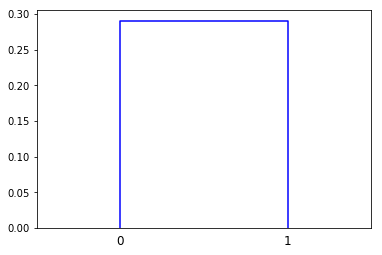

In [6]:
dist = get_distance('a little bird', 'a little bird chirps', myvectorizer)
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
dendrogram(linkage(dist, method="ward"))

### Try changing the sentences above to be the same or totally different.  How does it change the Y axis bar?

In the picture above, the cross bar is at the distance measure of the two documents. The documents are 0 and 1 on the X axis.

For more than two documents, they are compared pairwise and branches are drawn at the level of their distance, with the most similar being grouped together first. Then groups are grouped, by similarity to each other. This is called **hierarchical clustering.**

For instance, one method, "Ward's", uses this algorithm:

1. Start with each text in its own cluster. (We work "bottom up".)
2. Until only a single cluster remains, repeat:
  *    Find the closest clusters and merge them. The distance between two clusters is the change in the sum of squared distances when they are merged.

4. Finally, return a tree containing a record of cluster-merges.

(See e.g., https://de.dariah.eu/tatom/working_with_text.html)

There are other methods documented [here](http://www.ncss.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Hierarchical_Clustering-Dendrograms.pdf) including "single", "median", "average", "centroid".  There is also more mathematical explanation in the doc page 
on the linkage options available here: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html

## Doing It With Real Files

In [7]:
names = nlp.get_filenames("data/jobs/web/")

### This command creates a dictionary of the name of the file as key, and text as value:

In [8]:
texts = nlp.load_texts_as_string(names)

In [9]:
list(texts.keys())[0:10]

['data/jobs/web/web_595b4c8e9edd5213dc823160.txt',
 'data/jobs/web/web_5959fa8d9edd527acc4baedb.txt',
 'data/jobs/web/web_5958a9459edd5263d72f3ff8.txt',
 'data/jobs/web/web_595b4c8e9edd5213dc82316c.txt',
 'data/jobs/web/web_595b4c8e9edd5213dc82315a.txt',
 'data/jobs/web/web_595b4c8e9edd5213dc823169.txt',
 'data/jobs/web/web_5959fa8e9edd527acc4baeeb.txt',
 'data/jobs/web/web_5957583a9edd524a345bd279.txt',
 'data/jobs/web/web_5959fa8e9edd527acc4baeea.txt',
 'data/jobs/web/web_5959fa8e9edd527acc4baeef.txt']

In [11]:
# using a key to retrieve the value:
texts['data/jobs/web/web_595b4c8e9edd5213dc82315d.txt']

"Chef de Projet Digital confirmé (H/F)\nSmile est le 1er intégrateur européen de solutions Open Source. Présent dans 9 pays, avec 18 agences réparties en France et à l’étranger et certifié Happy at Work Vous aimez l’Open Source et ses communautés ? Devenez Smilien ! Qu'est ce qu’un Smilien ? un passionné de l’Open Source, qui relève les défis techniques. Un Smilien aime exprimer ses talents, aux côtés d’experts au sein d’équipes pluridisciplinaires. Un Smilien aime porter l’Open Source à travers des initiatives comme la Smile Academy et l’ Open Source School . Nous recherchons un futur Smilien pour intervenir sur des projets variés (site, appli, R&D….) reposant sur de nombreuses technologies Open Source Mission : Au sein de l'équipe en charge du pilotage de l’évolution des différentes plateformes digitales de notre client, vos principales missions sont : · Garantir la vision fonctionnelle de nos produits digitaux ; · Garantir la qualité des services et des évolutions ; · Aide à la prio

Now we use the scikit-learn "vectorizer" to make arrays of the tf-idf values per text.

In [12]:
# Using the text part of the dict, not the keys which are filenames
tfidf = TfidfVectorizer(tokenizer=nlp.tokenize_clean_stem).fit_transform(texts.values())

We need to convert this to a simple numpy array (a type of list) to use for the clustering.

In [13]:
vectors = tfidf.toarray()

This gets us the input we need for clustering and making dendrograms.  They look like this (a shortened display...) A lot are 0 because those words aren't in all the documents.

In [14]:
vectors

array([[ 0.        ,  0.        ,  0.        , ...,  0.03303012,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Graphing the Cluster Tree with SciPy

In [15]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

Reminder: Scipy's pdist is pairwise distance - see http://docs.scipy.org/doc/scipy/reference/spatial.distance.html
You can use cosine here as well! or a host of other options...

In [16]:
dist = pdist(vectors, metric='cosine')  # look at the manpage and pick a different measure to try

In [17]:
# Now we have scores for the cosine distance between the vectors and
# we can do the linkage to build a tree two by two!
link = linkage(dist, method="ward")

In [ ]:
# this is a base diagram, using defaults... it will be ugly and take up a lot of room. Just FYI.
dendrogram(link)  # this plotting function has a ton of things you can manipulate if you look at the docs.

## Let's do this with a nicer layout now... 

In [39]:
def make_dend(data, method='ward', labels=None, height=8):
    from pylab import rcParams
    dist = pdist(data, metric='cosine')
    link = linkage(dist, method=method)
    rcParams['figure.figsize'] = 6, height
    rcParams['axes.labelsize'] = 5
    if not labels:
        dend = dendrogram(link, orientation='right') #labels=names)
    else:
        # the label is actually the file + it's number in the list. See notes below on enumerate.
        dend = dendrogram(link, orientation='right', labels=[str(i) + '_' + label for i, label in enumerate(labels)])
    return dist

def clean_filenames(paths):
    # Makes labels that are just the root filename, no path part, and minus .txt
    import os
    return [os.path.basename(path).strip(".txt") for path in paths]

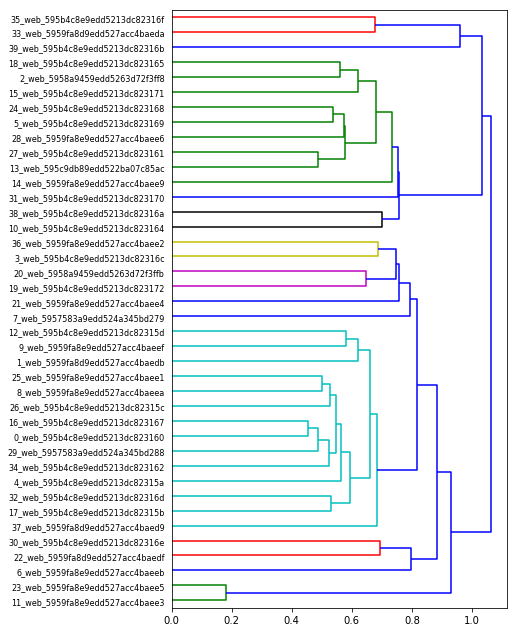

In [21]:
# try this with ward method, complete, average, single, etc.
dist = make_dend(vectors, method='ward', height=11, labels=clean_filenames(texts.keys()))

## Let's inspect a pair that are grouped closely in the cosine-similarity tree. You can find them in your data folder and take a quick look.

This is a helper function to look up the right filename and get you the text. You must use the same dict you created to use the labels in the dendrogram above.  This relies on our use of the function "enumerate" to count the filenames we used, so we could label the filenames with a count (in front of the long filename).  We can use this counter number to make it easier to find the file text.

In [38]:
for count, value in enumerate(['fred', 'sally', 'sam']):
    print(count, value)

0 fred
1 sally
2 sam


In [28]:
def get_text_from_number(textdict, number):
    """Requires your dictionary of texts with filenames as keys - same used for labels above - 
    Returns the text for the corresponding file for the number in the list.
    """
    filename = list(textdict.keys())[number]
    return textdict[filename]

In [31]:
# get the file name for an index in the tree

get_text_from_number(texts, 35)

'Assistant Publication de produits et contenus web\nRattaché au pôle publication au sein de la direction web, l’assistant publication est en charge de la publication des produits et des contenus sur le site internet : - Publication des produits = topages, maillages, création de nomenclatures… - Publication de contenus = articles, diaporamas, vidéos… - Certification de la désignation des références produit - Création de fiches produits spécifiques\n'

In [32]:
get_text_from_number(texts, 33)

'Assistant coordination shooting web H/F\nAu sein de la direction E-Commerce et CRM, vous assistez le chargé de collection digitale en participant à la mise en ligne des produits Pimkie, avec un seul objectif en tête : avoir un catalogue produit à jour ! Plus précisément : - Vous réceptionnez et gérez les échantillons produits web, - Vous participez à la préparation et à la coordination des shootings web, - Vous suivez les mises en ligne produits sur tous nos sites pays, - Vous mettez en place des actions de cross selling , - Vous effectuez le E-merchandising des nouveautés produits.\n'

Now let's use a reduced data set, so we can look at it a little closer.  We'll use the books.

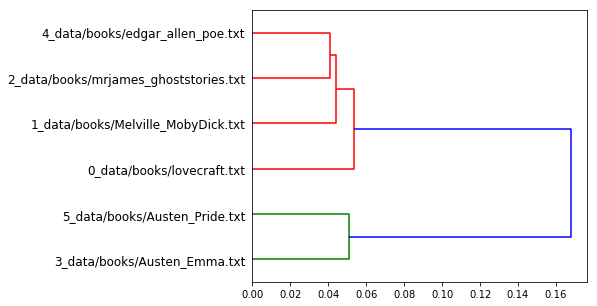

In [41]:
books = nlp.get_filenames("data/books")
booktexts = nlp.load_texts_as_string(books)
tfidf2 = TfidfVectorizer().fit_transform(booktexts.values())
vectorsbooks = tfidf2.toarray()
#dist = pdist(vectors, metric='cosine')
distbooks = make_dend(vectorsbooks, height=5, method="average", labels=booktexts.keys())


## Heatmap Displays

In [42]:
# Code borrowed from: http://nbviewer.ipython.org/github/OxanaSachenkova/hclust-python/blob/master/hclust.ipynb

def make_heatmap_matrix(dist, method='complete'):
    """ Pass in the distance matrix; method options are complete or single """
    # Compute and plot first dendrogram.
    fig = plt.figure(figsize=(10,10))
    # x y width height (left, bottom, w, h)
    ax1 = fig.add_axes([0.05,0.1,0.2,0.6])
    Y = linkage(dist, method=method)
    Z1 = dendrogram(Y, orientation='right')
    ax1.set_xticks([])  # suppress labels on height.
    # yticks are the number labels, let them live.

    # Compute and plot second dendrogram.
    ax2 = fig.add_axes([0.3,0.74,0.6,0.2])
    Z2 = dendrogram(Y)
    #ax2.set_xticks([])
    #ax2.set_yticks([])

    #Compute and plot the heatmap
    axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
    idx1 = Z1['leaves']
    idx2 = Z2['leaves']
    D = squareform(dist)
    D = D[idx1,:]
    D = D[:,idx2]
    im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=plt.cm.YlGnBu)
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
    plt.colorbar(im, cax=axcolor)

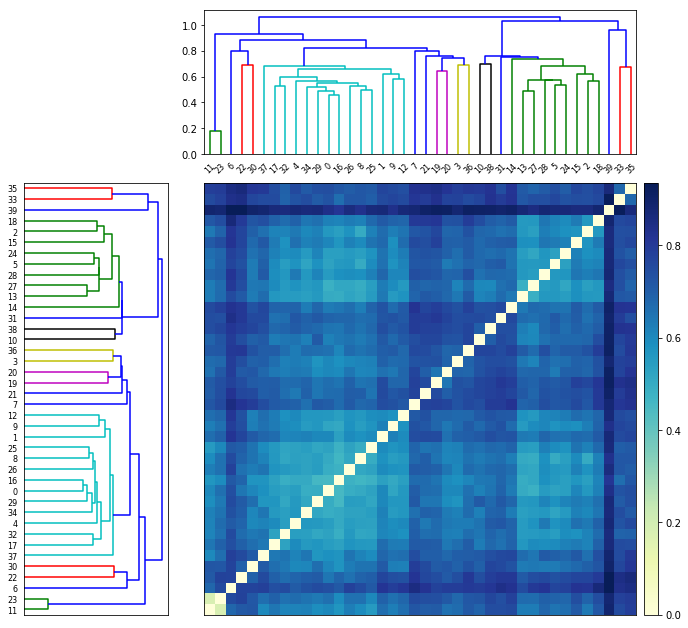

In [43]:
# Lighter blocks are more similar to each other, because this is showing distance as higher score! 
# The diagonal shows the item compared to itself, no distance.

make_heatmap_matrix(dist, method='ward')

In [44]:
list(texts.keys())[27]

'data/jobs/web/web_595b4c8e9edd5213dc823161.txt'

In [45]:
list(texts.keys())[9]

'data/jobs/web/web_5959fa8e9edd527acc4baeef.txt'

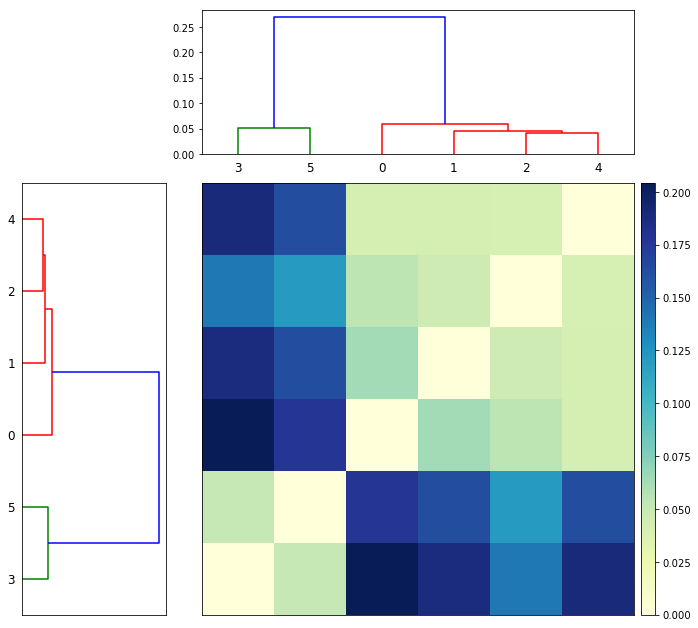

In [48]:
# Lighter blocks are more similar to each other, because this is showing distance as higher score! 
# The diagonal shows the item compared to itself, no distance.

make_heatmap_matrix(distbooks, method='ward')

The way to read that is that you are comparing all the documents to each other. Lighter sections mean more similar; you can see similarities across the tree structure if you carefully follow the squares.  The white diagonal is every document compared to itself, so it's always white -- score of 0 distance.

You can use hierarchical clustering to produce a number of cluster, just link we ask for in K-Means.  The way you do that is to just "cut" the tree at a certain height.  For instance:

<img src="assets/partitional.JPG" height="300">

All the "leaf" nodes (or documents) under a cut are the members of that cluster.

Now look at this slide: the relationship on the scatterplot to the hierarchical chart shows that the closer points are more similar leafs in the tree.

<img src="assets/slide_48.jpg" height="300">

With hierarchical information, you can make a principled decision on how many groups you want to retain based on similarities.

### A Recent Analysis using these techniques (in R):

http://kaylinwalker.com/tidy-text-beer/


### More review

You might find this basic overview of some of the python text comparisons we just did in python helpful too:  https://de.dariah.eu/tatom/working_with_text.html